In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
import time

import os
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import torchvision.models as models




In [ ]:
# def gen_edge_mask(mask):
#     # Convert mask to binary image
#     mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]
    
#     # Compute edges using the Canny edge detection algorithm
#     edges = cv2.Canny(np.uint8(mask * 255), 100, 200)
    
#     # Dilate edges to make them thicker
#     kernel = np.ones((3, 3), np.uint8)
#     edges = cv2.dilate(edges, kernel, iterations=1)
    
#     # Return the edge mask
#     return edges

In [3]:
# transform = transforms.Compose([
#                     transforms.ToTensor(), 
#             ])

# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset=datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [4]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,shuffle=True, num_workers=3)

# testloader = torch.utils.data.DataLoader(testset,batch_size=10,shuffle=True,num_workers=3)

In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CASIA(Dataset):
    def __init__(self, authentic_path, tampered_path, groundtruth_path,transform=None):
        self.authentic_path = authentic_path
        self.tampered_path = tampered_path
        self.groundtruth_path = groundtruth_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.load_dataset()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def load_dataset(self):
        # Load authentic images
        for filename in os.listdir(self.authentic_path):
            img_path = os.path.join(self.authentic_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            self.labels.append(0) # 0 for authentic

        # Load tampered images
        for filename in os.listdir(self.tampered_path):
            img_path = os.path.join(self.tampered_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            self.labels.append(1) # 1 for tampered

        # Load ground truth images
        for filename in os.listdir(self.groundtruth_path):
            img_path = os.path.join(self.groundtruth_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            self.labels.append(2) # 2 for ground truth



    


In [6]:
authentic_path = r'C:\Users\pchhl\OneDrive\Desktop\MVS\CASIA2\Au'
tampered_path = r'C:\Users\pchhl\OneDrive\Desktop\MVS\CASIA2\Tp'
groundtruth_path = r'C:\Users\pchhl\OneDrive\Desktop\MVS\CASIA2\Casia 2 Groundtruth'

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset = CASIA(authentic_path, tampered_path,groundtruth_path, transform=transform)

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [7]:
dataiter = iter(dataloader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 64, 64])
torch.Size([2])


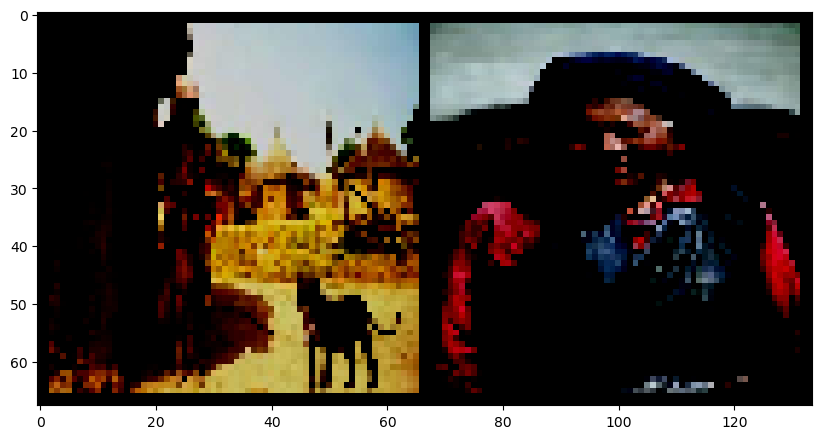

In [8]:
print(images.shape)
print(labels.shape)

def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


imshow(torchvision.utils.make_grid(images))

##### Bayar CNN or Constrained CNN

In [9]:
class BayarConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.minus1 = (torch.ones(self.in_channels, self.out_channels, 1) * -1.000)

        super(BayarConv2d, self).__init__()
        # only (kernel_size ** 2 - 1) trainable params as the center element is always -1
        self.kernel = nn.Parameter(torch.rand(self.in_channels, self.out_channels, kernel_size ** 2 - 1),
                                   requires_grad=True)


    def bayarConstraint(self):
        self.kernel.data = self.kernel.permute(2, 0, 1)
        self.kernel.data = torch.div(self.kernel.data, self.kernel.data.sum(0))
        self.kernel.data = self.kernel.permute(1, 2, 0)
        ctr = self.kernel_size ** 2 // 2
        real_kernel = torch.cat((self.kernel[:, :, :ctr], self.minus1.to(self.kernel.device), self.kernel[:, :, ctr:]), dim=2)
        real_kernel = real_kernel.reshape((self.out_channels, self.in_channels, self.kernel_size, self.kernel_size))
        return real_kernel

    def forward(self, x):
        x = F.conv2d(x, self.bayarConstraint(), stride=self.stride, padding=self.padding)
        return x

In [11]:
class BayarConv(nn.Module):
    def __init__(self):
        super(BayarConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=2, bias=False)

        weight = self.conv1.weight.data
        sum_all_except_center = torch.sum(weight[:, :, :, :] - weight[:, :, 2:3, 2:3], dim=(1, 2, 3), keepdim=True)
        # weight[:, :, :, :] -= weight[:, :, 2:3, 2:3]
        weight[:, :, :, :] /= sum_all_except_center
        weight[:, :, 2:3, 2:3] = -1.0

        self.conv.weight.data[:, :, :, :] = weight

        

    def forward(self, x):
        
        x = self.conv1(x)


        with torch.no_grad():
            weight = self.conv1.weight.data
            sum_all_except_center = torch.sum(weight[:, :, :, :] - weight[:, :, 2:3, 2:3], dim=(1, 2, 3), keepdim=True)
            weight[:, :, :, :] -= weight[:, :, 2:3, 2:3]
            weight[:, :, :, :] /= sum_all_except_center
            weight[:, :, 2:3, 2:3] = -1.0
            self.conv.weight.data[:, :, :, :] = weight
            
        return x

##### ERB

In [12]:
class ERB(nn.Module):
    def __init__(self,in_channels,strides):
        super(ERB,self).__init__()

        self.relu=nn.ReLU()
        self.batch_norm=nn.BatchNorm2d(1)
        self.cnn_1=nn.Conv2d(in_channels,1,kernel_size=1,stride=strides,padding=0)
        self.cnn_2=nn.Conv2d(1,1,kernel_size=3,stride=strides,padding=1)

    def forward(self,x):
        temp=x
        temp=self.cnn_1(temp)
        x1=self.cnn_2(temp)
        x1=self.batch_norm(x1)
        x1=self.relu(x1)
        x1=self.cnn_2(x1)

        fin=temp+x1

        return fin

In [13]:
erb=ERB(512,1)
erb(torch.randn(10, 512, 4, 4) ).shape

torch.Size([10, 1, 4, 4])

##### Sobel

In [14]:
class Sobel_layer(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Sobel_layer, self).__init__()
        self.conv_x = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False)
        self.batch_norm=nn.BatchNorm2d(out_channels)
        self.sigmoid=nn.Sigmoid()
        # self.normm=torch.norm()

        for j in range(out_channels):
            for i in range(in_channels):
                self.conv_x.weight.data[j, i, :, :] = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        
        # self.conv_x.weight.data[1, 0, :, :] = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        # self.conv_x.weight.data[1, 1, :, :] = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        # self.conv_x.weight.data[1, 2, :, :] = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

        self.conv_y = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1,bias=False)

        for j in range(out_channels):
            for i in range(in_channels):
                self.conv_y.weight.data[j, i, :, :] = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
      
        # self.conv_y.weight.data[1, 0, :, :] = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        # self.conv_y.weight.data[1, 1, :, :] = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        # self.conv_y.weight.data[1, 2, :, :] = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    def forward(self, x):
        temp_x=self.conv_x(x)
        temp_x=self.batch_norm(temp_x)
        temp_y=self.conv_y(x)
        temp_y=self.batch_norm(temp_y)

        temp = torch.sqrt(torch.pow(temp_x, 2) + torch.pow(temp_y, 2))


        temp=self.sigmoid(temp)

        # print(temp)
        # print(x.shape)
        
        fin=temp*x
        return fin


##### Positional Attention Module

In [15]:
class Position(nn.Module):
    def __init__(self):
        super(Position,self).__init__()
        self.conv1=nn.Conv2d(4096,512,kernel_size=1,stride=1,padding=0)
        self.conv2=nn.Conv2d(4096,4096,kernel_size=1,stride=1,padding=0)

        self.sm=nn.Softmax()
        self.alpha = nn.Parameter(torch.tensor(0.0), requires_grad=True)
    
    def forward(self,x):
        b,c,h,w=x.size()
        temp_1=self.conv1(x)
        
        b1,c1,h1,w1=temp_1.shape
        temp_1 = temp_1.reshape(b1,c1, h1*w1)
        # print(temp_1.shape)

        temp_2=torch.transpose(temp_1,2,1)

        # print(temp_2.shape)
        position_attention_map=torch.bmm(temp_2,temp_1)
        # print(position_attention_map.shape)
        position_attention_map=self.sm(position_attention_map)

        temp_2=self.conv2(x)
        # print(temp_2.shape)
        b2,c2,h2,w2=temp_2.shape

        temp_2 = temp_2.reshape(b2, c2,h2*w2)

        position_attention_map=torch.transpose(position_attention_map,2,1)
        fin=torch.bmm(temp_2,position_attention_map)
        # print(fin.shape)

        fin=fin.reshape(b,c,h,w)   
        return self.alpha*fin+x


##### Channel Attention Module

In [16]:
class Channel(nn.Module):
    def __init__(self):
        super(Channel,self).__init__()

        self.sm=nn.Softmax()
        self.beta = nn.Parameter(torch.tensor(0.0), requires_grad=True)
    
    def forward(self,x):
        b,c,h,w=x.size()
        temp_1 = x.reshape(b, c,h*w)
        # print(temp_1.size())
        temp_2=torch.transpose(temp_1,2,1)
        channel_attention_map=torch.bmm(temp_1,temp_2)

        channel_attention_map=self.sm(channel_attention_map)
        # print(channel_attention_map.size())
        channel_attention_map=torch.transpose(channel_attention_map,2,1)

        fin=torch.bmm(temp_2,channel_attention_map)
        fin=fin.reshape(b,c,h,w)   
        return self.beta*fin+x

##### Dual Attention Network

In [17]:
class Dual(nn.Module):
    def __init__(self):
        super(Dual,self).__init__()
        self.position = Position()
        self.channel = Channel() 
        self.conv=nn.Conv2d(4096,1,kernel_size=1)

    def forward(self,x):
        temp1=self.position(x)
        temp2=self.channel(x)
        temp_3=temp1+temp2
        return self.conv(temp_3)

In [18]:
dual=Dual()
input_tensor = torch.randn(2, 4096, 32, 32) 

dual(input_tensor).shape

torch.Size([2, 1, 32, 32])

In [14]:
# resnet50=models.resnet50(pretrained=True)
# input_resize=torch.nn.functional.interpolate(images,size=(224,224))
# print(input_resize.shape)
# conv_layer = nn.Sequential(*list(resnet50.children())[:-2])
# output_tensor = conv_layer(input_resize)
# mx=nn.MaxPool2d(7)
# output_tensor=mx(output_tensor)
# flatten=nn.Flatten()
# output_tensor=flatten(output_tensor)
# linar=nn.Linear(2048,8*8*256)
# output_tensor=linar(output_tensor)
# output_tensor = output_tensor.view(100, 256, 8, 8)
# print(output_tensor.shape)




In [15]:
# dataiter = iter(trainloader)
# images, labels = next(dataiter)


In [20]:
class MyResNet50(nn.Module):
    def __init__(self,in_channels):
        super(MyResNet50, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(*list(models.resnet50().children())[4])
        self.layer2 = nn.Sequential(*list(models.resnet50().children())[5])
        self.layer3 = nn.Sequential(*list(models.resnet50().children())[6])
        self.layer4 = nn.Sequential(*list(models.resnet50().children())[7])
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(2048, 1000)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        return x


# resnet50_2 = MyResNet50(256) 

# input_tensor = torch.randn(10, 256, 8, 8) 


# output_tensor_2 = resnet50_2(input_tensor) 

# print(output_tensor_2.shape) 


In [21]:
class MVSS(nn.Module):
    def __init__(self):
        super(MVSS,self).__init__()
        resnet50=models.resnet50(pretrained=True)
        self.conv_layer = nn.Sequential(*list(resnet50.children())[:-2])
        self.mx=nn.MaxPool2d(7)

        self.gmp=nn.AdaptiveMaxPool2d(64)

        self.flatten=nn.Flatten()
        self.sobel_1=Sobel_layer(256,256)
        self.sobel_2=Sobel_layer(512,512)
        self.sobel_3=Sobel_layer(1024,1024)
        self.sobel_4=Sobel_layer(2048,2048)

        self.erb1=ERB(256,1)
        self.erb2=ERB(512,1)
        self.erb3=ERB(1024,1)
        self.erb4=ERB(2048,1)
        self.erb5=ERB(1,1)

        self.scale1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.scale2 = nn.Upsample(scale_factor=4, mode="nearest")
        self.sig=nn.Sigmoid()

        self.bayar=BayarConv2d(3,3)
        self.dual=Dual()



    def forward(self,x):

        b,c,h,w=x.size()
        input_resize=torch.nn.functional.interpolate(x,size=(224,224))
        output_1=self.conv_layer(input_resize)
        output_1=self.mx(output_1)
        output_1=self.flatten(output_1)
        linear_1=nn.Linear(2048,h//4*w//4*256)
        res_1=linear_1(output_1).view(b, 256, w//4, h//4)   
        # print(res_1.shape,  "Required 10, 256, 8, 8")
        sb_1=self.sobel_1(res_1)
        erb_1=self.erb1(sb_1)


        input_resize_2=torch.nn.functional.interpolate(res_1,size=(224,224))      
        resnet_2=MyResNet50(256)
        output_2=resnet_2(input_resize_2)
        output_2=self.flatten(output_2)
        linear_2=nn.Linear(2048,h//8*w//8*512)
        res_2=linear_2(output_1).view(b, 512, w//8, h//8)     
        # print(res_2.shape,  "Required 10, 512, 4, 4")
        sb_2=self.sobel_2(res_2)
        erb_2=self.erb2(sb_2)


        input_resize_3=torch.nn.functional.interpolate(res_2,size=(224,224))
        resnet_3=MyResNet50(512)
        output_3=resnet_3(input_resize_3)
        output_3=self.mx(output_3)
        output_3=self.flatten(output_3)
        linear_3=nn.Linear(2048,h//16*w//16*1024)
        res_3=linear_3(output_3).view(b, 1024, w//16, h//16)       
        # print(res_3.shape,  "Required 10, 1024, 2, 2")
        sb_3=self.sobel_3(res_3)
        erb_3=self.erb3(sb_3)


        input_resize_4=torch.nn.functional.interpolate(res_3,size=(224,224))
        resnet_4=MyResNet50(1024)
        output_4=resnet_4(input_resize_4)
        output_4=self.mx(output_4)
        output_4=self.flatten(output_4)
        linear_4=nn.Linear(2048,h//16*w//16*2048)
        res_4=linear_4(output_4).view(b, 2048, w//16, h//16)          
        # print(res_4.shape,  "Required 10, 2048, 2, 2")
        sb_4=self.sobel_4(res_4)
        erb_4=self.erb4(sb_4)


        erb_out1=erb_1+self.scale1(erb_2)
        erb_out_2=self.erb5(erb_out1)
        erb_out_3=self.scale2(erb_3)+erb_out_2
        erb_out_4=self.erb5(erb_out_3)
        erb_out_5=self.scale2(erb_4)+erb_out_4
        final_erb_out=self.erb5(erb_out_5)

        edge_out=self.sig(final_erb_out)

        bayar_out=self.bayar(x)

        input_resize_b1=torch.nn.functional.interpolate(bayar_out,size=(224,224))
        output_1=self.conv_layer(input_resize_b1)
        output_1=self.mx(output_1)
        output_1=self.flatten(output_1)
        linear_1=nn.Linear(2048,h//4*w//4*256)
        res_11=linear_1(output_1).view(b, 256, w//4, h//4)   
      


        input_resize_b2=torch.nn.functional.interpolate(res_11,size=(224,224))      
        resnet_2=MyResNet50(256)
        output_2=resnet_2(input_resize_b2)
        output_2=self.flatten(output_2)
        linear_2=nn.Linear(2048,h//8*w//8*512)
        res_22=linear_2(output_1).view(b, 512, w//8, h//8)     
      


        input_resize_b3=torch.nn.functional.interpolate(res_22,size=(224,224))
        resnet_3=MyResNet50(512)
        output_3=resnet_3(input_resize_b3)
        output_3=self.mx(output_3)
        output_3=self.flatten(output_3)
        linear_3=nn.Linear(2048,h//16*w//16*1024)
        res_33=linear_3(output_3).view(b, 1024, w//16, h//16)       
        


        input_resize_b4=torch.nn.functional.interpolate(res_33,size=(224,224))
        resnet_4=MyResNet50(1024)
        output_4=resnet_4(input_resize_b4)
        output_4=self.mx(output_4)
        output_4=self.flatten(output_4)
        linear_4=nn.Linear(2048,h//16*w//16*2048)
        res_44=linear_4(output_4).view(b, 2048, w//16, h//16)          
       
        dual_concat=torch.cat([res_4,res_44],dim=1)

        dual_out=self.dual(dual_concat)

        final_dual=self.sig(dual_out)

        global_max_val=self.gmp(final_dual)

        return edge_out,final_dual,global_max_val

        







In [22]:
mvss=MVSS()
a,b,c=mvss(images)

In [26]:
# imshow(torchvision.utils.make_grid(b))

##### Train using all losses

In [54]:
class Diceloss(torch.nn.Module):
    def __init__(self):
        super(Diceloss, self).__init__()
    def forward(self, pred, target):
        pred = pred.reshape(pred.shape[1], pred.shape[2])
        target = target.reshape(target.shape[1], target.shape[2])
        h, w = pred.shape
        numerator, denominator = 0, 0
        for i in range(h):
            for j in range(w):  
                numerator += pred[i][j]*target[i][j]
                denominator += pred[i][j]*pred[i][j] + target[i][j]*target[i][j]
            
        return 1-(2*numerator)/denominator
    
loss_dice = Diceloss()
loss_bce=nn.BCELoss()
